# Лабораторная работа №4:  
Сравнение YOLOv8(CNN) и RT-DETR v2 (transformer) в детекции

In [ ]:
## 1. Установка окружения и зависимостей

import os
os.environ["TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD"] = "1"
!pip install -q ultralytics==8.2.26 transformers==4.51.3 datasets torchmetrics opencv-python tqdm pyyaml


## 2. Определение устройства
import torch
# Выбираем GPU, если доступен, иначе CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Используем устройство: {device}")

Используем устройство: cuda


In [ ]:
## 3. Скачивание и распаковка датасета COCO128

from pathlib import Path
import urllib.request, zipfile

DATA_URL = "https://github.com/ultralytics/yolov5/releases/download/v1.0/coco128.zip"
ZIP_PATH = Path("coco128.zip")
DATA_DIR = Path("coco128")

if not DATA_DIR.exists():
    urllib.request.urlretrieve(DATA_URL, ZIP_PATH)
    with zipfile.ZipFile(ZIP_PATH, 'r') as z:
        z.extractall()

IMG_DIR = DATA_DIR / "images" / "train2017"
LBL_DIR = DATA_DIR / "labels" / "train2017"
print(f"Изображений: {len(list(IMG_DIR.glob('*.jpg')))}, Аннотаций: {len(list(LBL_DIR.glob('*.txt')))})")

Изображений: 128, Аннотаций: 128)


In [ ]:
## 4. Подготовка Dataset и DataLoader

import random, torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from pathlib import Path

class YOLOTxtDataset(Dataset):
    def __init__(self, img_dir, lbl_dir, sample_frac=1.0):
        self.img_paths = sorted(Path(img_dir).glob("*.jpg"))
        if sample_frac < 1.0:
            self.img_paths = random.sample(self.img_paths, int(len(self.img_paths)*sample_frac))
        self.lbl_dir = Path(lbl_dir)

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        path = self.img_paths[idx]
        img = Image.open(path).convert("RGB")
        w, h = img.size
        boxes, labels = [], []
        txt = self.lbl_dir / f"{path.stem}.txt"
        if txt.exists():
            for line in open(txt):
                cls, xc, yc, bw, bh = map(float, line.split())
                x_min = (xc - bw/2) * w
                y_min = (yc - bh/2) * h
                x_max = (xc + bw/2) * w
                y_max = (yc + bh/2) * h
                boxes.append([x_min, y_min, x_max, y_max])
                labels.append(int(cls))
        return img, {"boxes": torch.tensor(boxes, dtype=torch.float32), "labels": torch.tensor(labels, dtype=torch.long)}

# Валидационный загрузчик
dataset_val = YOLOTxtDataset(IMG_DIR, LBL_DIR, sample_frac=0.5)
val_loader = DataLoader(dataset_val, batch_size=4, shuffle=False, collate_fn=lambda x: list(zip(*x)))

In [ ]:
## 5. Обучение и валидация YOLOv8

from ultralytics import YOLO

data_yaml = "ultralytics/cfg/datasets/coco128.yaml"
yolo = YOLO("yolov8n.pt")
yolo.train(data=data_yaml, epochs=10, imgsz=640, batch=16, device=device)
yolo_metrics = yolo.val(data=data_yaml, imgsz=640, device=device)
print(yolo_metrics.box.map50, yolo_metrics.box.map)

New https://pypi.org/project/ultralytics/8.3.133 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.26 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=ultralytics/cfg/datasets/coco128.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=

/usr/local/lib/python3.11/dist-packages/ultralytics/nn/tasks.py:732: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  ckpt = torch.load(file, map_location="cpu")


Model summary: 225 layers, 3157200 parameters, 3157184 gradients, 8.9 GFLOPs

Transferred 355/355 items from pretrained weights
TensorBoard: Start with 'tensorboard --logdir runs/detect/train3', view at http://localhost:6006/


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


/usr/local/lib/python3.11/dist-packages/ultralytics/nn/tasks.py:732: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  ckpt = torch.load(file, map_location="cpu")
train: Scanning /content/datasets/coco128/labels/train2017.cache... 126 images, 2 backgrounds, 0 corrupt: 100%|██████████| 128/128 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



/usr/local/lib/python3.11/dist-packages/ultralytics/data/augment.py:935: UserWarning: Argument(s) 'quality_lower' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=75, p=0.0),
val: Scanning /content/datasets/coco128/labels/train2017.cache... 126 images, 2 backgrounds, 0 corrupt: 100%|██████████| 128/128 [00:00<?, ?it/s]


Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000119, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train3
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.11/dist-packages/ultralytics/data/augment.py:935: UserWarning: Argument(s) 'quality_lower' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=75, p=0.0),



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      2.57G       1.19      1.383      1.216        121        640: 100%|██████████| 8/8 [00:01<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.68it/s]


                   all        128        929      0.637      0.535       0.61      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      2.47G      1.146      1.373      1.198        113        640: 100%|██████████| 8/8 [00:00<00:00,  8.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.93it/s]


                   all        128        929      0.674      0.553      0.623      0.458

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      2.47G      1.177      1.343      1.229        118        640: 100%|██████████| 8/8 [00:00<00:00,  8.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.95it/s]


                   all        128        929      0.664      0.566      0.635      0.471

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10       2.5G      1.154      1.277        1.2         68        640: 100%|██████████| 8/8 [00:00<00:00,  8.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.14it/s]


                   all        128        929      0.718      0.559      0.657      0.489

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      2.43G      1.144      1.223      1.192         95        640: 100%|██████████| 8/8 [00:00<00:00,  9.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.12it/s]


                   all        128        929      0.699      0.573      0.665      0.501

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      2.44G      1.103      1.216      1.162        122        640: 100%|██████████| 8/8 [00:00<00:00,  9.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.76it/s]


                   all        128        929      0.714      0.584      0.679      0.507

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      2.47G      1.087      1.155       1.15         75        640: 100%|██████████| 8/8 [00:00<00:00,  9.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.69it/s]


                   all        128        929      0.689      0.615       0.69      0.517

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      2.46G      1.113       1.13      1.177        142        640: 100%|██████████| 8/8 [00:00<00:00,  8.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.95it/s]


                   all        128        929      0.676      0.634      0.699      0.524

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      2.49G      1.089      1.096      1.148        104        640: 100%|██████████| 8/8 [00:00<00:00,  9.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.93it/s]


                   all        128        929      0.677      0.657      0.705       0.53

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      2.46G      1.086      1.182      1.176        164        640: 100%|██████████| 8/8 [00:00<00:00,  9.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.77it/s]


                   all        128        929      0.675      0.662      0.706       0.53

10 epochs completed in 0.036 hours.


/usr/local/lib/python3.11/dist-packages/ultralytics/utils/torch_utils.py:507: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  x = torch.load(f, map_location=torch.device("cpu"))


Optimizer stripped from runs/detect/train3/weights/last.pt, 6.5MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 6.5MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics YOLOv8.2.26 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 168 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs


/usr/local/lib/python3.11/dist-packages/ultralytics/nn/tasks.py:732: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  ckpt = torch.load(file, map_location="cpu")
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.28it/s]


                   all        128        929      0.672      0.659      0.705       0.53
                person         61        254      0.791      0.693      0.782      0.571
               bicycle          3          6      0.948      0.333      0.366      0.322
                   car         12         46      0.718      0.239      0.329      0.197
            motorcycle          4          5      0.694      0.914      0.938      0.742
              airplane          5          6      0.713          1      0.955       0.76
                   bus          5          7      0.764      0.714      0.722      0.651
                 train          3          3      0.721      0.882      0.913      0.747
                 truck          5         12      0.817        0.5      0.526      0.374
                  boat          2          6      0.567      0.333      0.578      0.401
         traffic light          4         14      0.382      0.143      0.149      0.134
             stop sig

lr/pg0,▁▄▆▇██▇▆▄▂
lr/pg1,▁▄▆▇██▇▆▄▂
lr/pg2,▁▄▆▇██▇▆▄▂
metrics/mAP50(B),▁▂▃▄▅▆▇███
metrics/mAP50-95(B),▁▂▃▅▆▆▇▇██
metrics/precision(B),▁▄▃█▆█▅▄▄▄
metrics/recall(B),▁▂▃▂▃▄▅▇██
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,█▅▇▆▅▂▁▃▁▁


Ultralytics YOLOv8.2.26 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)


/usr/local/lib/python3.11/dist-packages/ultralytics/nn/tasks.py:732: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  ckpt = torch.load(file, map_location="cpu")


Model summary (fused): 168 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs


val: Scanning /content/datasets/coco128/labels/train2017.cache... 126 images, 2 backgrounds, 0 corrupt: 100%|██████████| 128/128 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.23it/s]


                   all        128        929      0.689      0.651      0.705      0.528
                person         61        254      0.806      0.689      0.787      0.573
               bicycle          3          6       0.99      0.333      0.378      0.331
                   car         12         46      0.714      0.217      0.322      0.193
            motorcycle          4          5      0.692      0.906      0.938      0.764
              airplane          5          6      0.716          1      0.955       0.76
                   bus          5          7        0.7      0.714      0.722      0.648
                 train          3          3      0.717      0.868      0.913      0.747
                 truck          5         12      0.906        0.5      0.537      0.368
                  boat          2          6      0.541      0.333      0.494      0.338
         traffic light          4         14      0.494      0.143      0.149      0.142
             stop sig


0: 640x448 2 persons, 1 suitcase, 69.9ms
Speed: 3.6ms preprocess, 69.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 448)


(np.float64(-0.5), np.float64(426.5), np.float64(639.5), np.float64(-0.5))

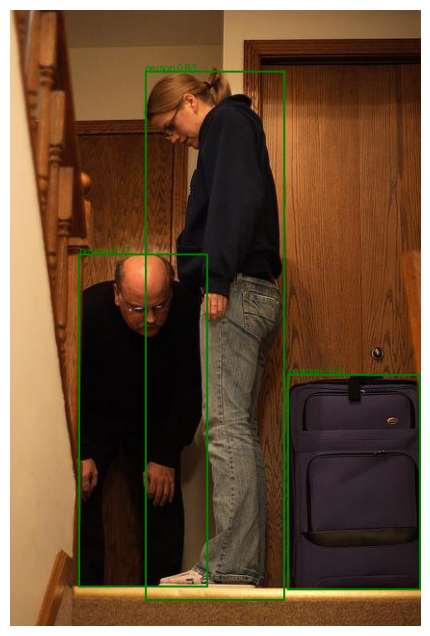

In [ ]:
## 6. Визуализация результатов детекции YOLOv8

import cv2
import matplotlib.pyplot as plt

# Берём первое изображение из валидации
demo_img_path = IMG_DIR / list(IMG_DIR.glob('*.jpg'))[0]
img0 = cv2.imread(str(demo_img_path))
img = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB)
# Инференс принимает np.ndarray в uint8
res = yolo(img)
boxes = res[0].boxes.xyxy.cpu().numpy()
cls = res[0].boxes.cls.cpu().numpy().astype(int)
conf = res[0].boxes.conf.cpu().numpy()
for (x1,y1,x2,y2),c,s in zip(boxes, cls, conf):
    cv2.rectangle(img, (int(x1),int(y1)), (int(x2),int(y2)), (0,255,0),2)
    cv2.putText(img, f"{yolo.names[c]} {s:.2f}", (int(x1),int(y1)-5), cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,255,0),1)
plt.imshow(img); plt.axis('off')

In [ ]:
## 7. Валидация RT-DETR v2

from transformers import RTDetrV2ForObjectDetection, RTDetrImageProcessor
from torchmetrics.detection.mean_ap import MeanAveragePrecision
import torch
from tqdm import tqdm

processor = RTDetrImageProcessor.from_pretrained('PekingU/rtdetr_v2_r18vd')
model = RTDetrV2ForObjectDetection.from_pretrained('PekingU/rtdetr_v2_r18vd').to(device).eval()
metric = MeanAveragePrecision(box_format='xyxy', iou_type='bbox').to(device)

for imgs, targets in tqdm(val_loader):
    inputs = processor(images=list(imgs), return_tensors='pt').to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    results = processor.post_process_object_detection(
        outputs,
        target_sizes=[(im.height, im.width) for im in imgs],
        threshold=0.005
    )
    preds = [
        {'boxes':r['boxes'].to(device), 'scores':r['scores'].to(device), 'labels':r['labels'].to(device)}
        for r in results
    ]
    gts = [
        {'boxes':t['boxes'].to(device), 'labels':t['labels'].to(device)}
        for t in targets
    ]
    metric.update(preds, gts)

rtdetr_metrics = metric.compute()
print(f"RT-DETR mAP@0.5: {rtdetr_metrics['map_50']:.3f}, mAP@0.5:0.95: {rtdetr_metrics['map']:.3f}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/444 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/5.44k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/80.9M [00:00<?, ?B/s]

  0%|          | 0/16 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)
100%|██████████| 16/16 [00:02<00:00,  6.19it/s]


RT-DETR mAP@0.5: 0.833, mAP@0.5:0.95: 0.662


In [ ]:
## 8. Сравнение скорости и метрик

import time, pandas as pd
import torch

def bench_fps(fn, size=640, n=50):
    dummy = torch.rand(1,3,size,size, device=device)
    torch.cuda.synchronize() if device=='cuda' else None
    t0 = time.time()
    for _ in range(n):
        _ = fn(dummy)
    torch.cuda.synchronize() if device=='cuda' else None
    return n/(time.time()-t0)

fps_y = bench_fps(lambda x: yolo(x.float()/255.0))
fps_r = bench_fps(lambda x: model(pixel_values=x))

df = pd.DataFrame({
    'model':['YOLOv8n','RT-DETR v2-R18'],
    'mAP@0.5':[float(yolo_metrics.box.map50), float(rtdetr_metrics['map_50'])],
    'mAP@0.5:0.95':[float(yolo_metrics.box.map), float(rtdetr_metrics['map'])],
    'FPS':[fps_y, fps_r],
    'Params_M':[3.2,14]
})
df



0: 640x640 (no detections), 9.1ms
Speed: 0.1ms preprocess, 9.1ms inference, 4.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.3ms
Speed: 0.0ms preprocess, 7.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.0ms
Speed: 0.0ms preprocess, 7.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.0ms
Speed: 0.0ms preprocess, 7.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 6.9ms
Speed: 0.0ms preprocess, 6.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 6.9ms
Speed: 0.0ms preprocess, 6.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.2ms
Speed: 0.0ms preprocess, 7.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.1ms
Speed: 0.0ms preprocess, 7.1ms inference, 1.2ms 

,model,mAP@0.5,mAP@0.5:0.95,FPS,Params_M
0,YOLOv8n,0.705212,0.528029,87.027819,3.2
1,RT-DETR v2-R18,0.832533,0.662133,24.999058,14.0


# Задание:
1) Заменить YOLOv8n на более близкую к конкуренту по числу параметров YOLOv8s, предоставить метрики и сделать вывод как показывают себя модели при более схожем числе параметров. Обучить обе модели (YOLOv8s и RT-DETR v2-R18) на всех 128 изображениях COCO128. Собрать метрики mAP@0.5 и mAP@0.5:0.95, FPS и визуализировать (например, bar-chart). Оценить изменение mAP и FPS: найти «точку перелома», при которой прирост точности начинает уступать падению скорости.  
2) Исходя из полученных результатов, сформулировать, в каких реальных задачах (видеонаблюдение, автомобильная электроника, дроны) стоит выбрать YOLO, а в каких — RT-DETR. Обосновать выбор с позиции «точность/скорость» и требований к ресурсам.  
3) Вынести в конфиг RT-DETR v2 количество decoder-слоев num_decoder_layers=4 вместо дефолтных 6. Переобучить модель на полной выборке. Сравнить mAP@0.5, mAP@0.5:0.95 и FPS с оригинальной RT-DETR v2.Проанализировать, в какой степени уменьшение числа слоёв влияет на глобальный контекст и качество локализации.